In [5]:
using Parameters

@with_kw struct ModelConfig
    nx::Int = 64
    ny::Int = 64
    nt::Int = 51
    nc_in::Int = 4
    nc_mid::Int = 128
    nc_lift::Int = 20
    nc_out::Int = 1
    mx::Int = 4
    my::Int = 4
    mt::Int = 4
    nblocks::Int = 1
    dtype::DataType = Float32
    partition::Vector{Int} = [1, 4] 
    TuckerRank::Vector{Int} = [2,2,2,2,2,2] ##need to adjust this
end
config = ModelConfig()

using ParametricOperators

mutable struct Model
    config::ModelConfig
    lifts::ParKron
    convs::Vector
    sconvs::Vector
    biases::Vector
    sconv_biases::Vector
    projects::Vector
    weight_mixes::Vector

    #first, function to get Tucker factors (ParMatrix)
    function TuckerCompress(size::Vector,rank::Vector,restriction::Vector)
        factors = []
        n = length(size)
        T = config.dtype
    
        core = ParMatrix(Complex{T},rank[1],prod(rank[2:n]))
        push!(factors,ParMatrix(Complex{T},size[1],rank[1]))
        for i  = 2:length(size)
            push!(factors,ParMatrix(Complex{T},rank[i],size[i]))
        end
        return ParTucker(core,factors,restriction)
    end

    function Model(config::ModelConfig)

        T = config.dtype
        
        sconvs = []
        convs = []
        projects = []
        sconv_biases = []
        biases = []
        weight_mixes = []
    
        weight_shape = [config.nc_lift, config.nc_lift, 2*config.mx, 2*config.my,
        config.mt, config.nblocks]
        weight_mix = TuckerCompress(weight_shape,config.TuckerRank,
        [config.mx, config.my, config.mt])
        push!(weight_mixes, weight_mix)

        function spectral_convolution(layer::Int)
    
            # Build 3D Fourier transform with real-valued FFT along time
            fourier_x = ParDFT(Complex{T}, config.nx)
            fourier_y = ParDFT(Complex{T}, config.ny)
            fourier_t = ParDFT(T, config.nt)
    
            # Build restrictions to low-frequency modes
            restrict_x = ParRestriction(Complex{T}, Range(fourier_x), [1:config.mx, config.nx-config.mx+1:config.nx])
            restrict_y = ParRestriction(Complex{T}, Range(fourier_y), [1:config.my, config.ny-config.my+1:config.ny])
            restrict_t = ParRestriction(Complex{T}, Range(fourier_t), [1:config.mt])
            
            restrict_dft = ParKron((restrict_y * fourier_y) ⊗ (restrict_x * fourier_x), (restrict_t * fourier_t) ⊗ ParIdentity(T, config.nc_lift))
    
            sconv = restrict_dft' * weight_mix(layer) * restrict_dft
            # sconv =  weight_mix(layer) 

    
            return sconv
        end
    
        # Lift Channel dimension
        lifts = ParKron(ParIdentity(T,config.ny) ⊗ ParIdentity(T,config.nx), ParIdentity(T,config.nt) ⊗ ParMatrix(T, config.nc_lift, config.nc_in, "ParMatrix_LIFTS:(1)"))
        bias = ParBroadcasted(ParMatrix(T, config.nc_lift, 1, "ParMatrix_BIAS:(1)"))
    
        # lifts = distribute(lifts, config.partition)
    
        push!(biases, bias)
    
        for i in 1:config.nblocks
    
            sconv_layer = spectral_convolution(i)
            conv_layer = ParKron(ParIdentity(T,config.ny) ⊗ ParIdentity(T,config.nx), ParIdentity(T,config.nt) ⊗ ParMatrix(T, config.nc_lift, config.nc_lift, "ParMatrix_SCONV:($(i))"))
            bias = ParBroadcasted(ParMatrix(T, config.nc_lift, 1, "ParMatrix_SCONV:($(i))"))
    
            # conv_layer = distribute(conv_layer, config.partition)
    
            push!(sconv_biases, bias)
            push!(sconvs, sconv_layer)
            push!(convs, conv_layer)
        end
    
        # Uplift channel dimension once more
        uc = ParKron(ParIdentity(T,config.ny) ⊗ ParIdentity(T,config.nx), ParIdentity(T,config.nt) ⊗ ParMatrix(T, config.nc_mid, config.nc_lift, "ParMatrix_LIFTS:(2)"))
        bias = ParBroadcasted(ParMatrix(T, config.nc_mid, 1, "ParMatrix_BIAS:(2)"))
    
        uc = distribute(uc, config.partition)
    
        push!(biases, bias)
        push!(projects, uc)
    
        # Project channel dimension
        pc = ParKron(ParIdentity(T,config.ny) ⊗ ParIdentity(T,config.nx), ParIdentity(T,config.nt) ⊗ ParMatrix(T, config.nc_out, config.nc_mid, "ParMatrix_LIFTS:(3)"))
        bias = ParBroadcasted(ParMatrix(T, config.nc_out, 1, "ParMatrix_BIAS:(3)"))
    
        pc = distribute(pc, config.partition)
    
        push!(biases, bias)
        push!(projects, pc)
    
        new(config, lifts, convs, sconvs, biases, sconv_biases, projects, weight_mixes)
    end
end
Model(config)

: 

: 

In [1]:

using Pkg
Pkg.activate("./")
using ParametricOperators


function TuckerCompress(size::Vector,rank::Vector,restriction::Vector)
    factors = []
    n = length(size)
    
    core = ParMatrix(T,rank[1],prod(rank[2:n]))
    push!(factors,ParMatrix(T,size[1],rank[1]))
    for i  = 2:length(size)
        push!(factors,ParMatrix(T,rank[i],size[i]))
    end
    return ParTucker(core,factors,restriction)
end

T = Float32
i = 5; b = 3; nx = 6; ny = 6; nt = 6; o = 5
mx = 2; my = 2; mt = 2
layer = 1
rank = [2,2,2,2,2]
tensor_size = [o,i,2*mx,2*my,mt]
restr = [2,2,2]
tensor  = TuckerCompress(tensor_size,rank,restr)


  Activating project at `~/Documents/Research/dfno`
Precompiling ParametricOperators
  ✗ Cairo_jll
  ✗ HarfBuzz_jll
  ✗ Pango_jll
  ✗ Graphviz_jll
  ✗ GraphViz
        Info Given ParametricOperators was explicitly requested, output will be shown live 
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/maQWh/ext/FluxCUDAExt/FluxCUDAExt.jl:57
  ✓ ParametricOperators
  1 dependency successfully precompiled in 19 seconds. 200 already precompiled.
  1 dependency had output during precompilation:
┌ ParametricOperators
│  [Output was shown above]
└  
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be availab

ParTucker{Float32, 5}(ParMatrix{Float32}(2, 16, UUID("3e8b8d8c-cef5-4cc2-a102-595b509ca929")), Any[ParMatrix{Float32}(5, 2, UUID("7bee2499-7727-4f00-acfb-9fa850fdcf28")), ParMatrix{Float32}(2, 5, UUID("6295d45e-68cf-404f-b8f1-e61181f131fa")), ParMatrix{Float32}(2, 4, UUID("98362e36-7788-46a4-a162-60d1d02de79c")), ParMatrix{Float32}(2, 4, UUID("bc7d10e7-4f4b-40ad-a2d2-cc5348b7a905")), ParMatrix{Float32}(2, 2, UUID("fbb5ecfd-e3d3-43fd-80a0-ffa4ec85ada1"))], [2, 2, 2], UUID("9d13315f-928f-48c1-bbe4-305bc94b4ba4"))

In [2]:
d = ParametricOperators.to_Dict(tensor)

Dict{String, Any} with 6 entries:
  "rank"        => Any[2, 2, 2, 2, 2]
  "shape"       => Any[5, 5, 4, 4, 2]
  "T"           => "Float32"
  "id"          => "UUID:9d13315f-928f-48c1-bbe4-305bc94b4ba4"
  "restriction" => [2, 2, 2]
  "type"        => "ParTucker"

In [3]:
ParametricOperators.from_Dict(typeof(tensor),d)

ParTucker{Float32, 5}(ParMatrix{Float32}(2, 16, UUID("797d86a4-c132-4d9a-ba7c-be6956677e57")), Any[ParMatrix{Float32}(5, 2, UUID("a70f7555-599d-4dc4-b3fb-53ca263e05ca")), ParMatrix{Float32}(2, 5, UUID("ab320ae0-00f9-4080-bb8f-d1ce813ab629")), ParMatrix{Float32}(2, 4, UUID("de352a5c-e5b0-41e0-885e-51f7363855d1")), ParMatrix{Float32}(2, 4, UUID("39f98607-940a-41eb-b0ac-b9e721fef7ee")), ParMatrix{Float32}(2, 2, UUID("e69945e2-8592-4c89-bd95-7c27ec31a837"))], [2, 2, 2], UUID("9d13315f-928f-48c1-bbe4-305bc94b4ba4"))

In [4]:

    # config::ModelConfig
    # lifts::ParKron
    # convs::Vector
    # sconvs::Vector
    # biases::Vector
    # sconv_biases::Vector
    # projects::Vector
    # weight_mixes::Vector

    #first, function to get Tucker factors (ParMatrix)
    function TuckerCompress(size::Vector,rank::Vector,restriction::Vector)
        factors = []
        n = length(size)
        T = config.dtype
    
        core = ParMatrix(Complex{T},rank[1],prod(rank[2:n]))
        push!(factors,ParMatrix(Complex{T},size[1],rank[1]))
        for i  = 2:length(size)
            push!(factors,ParMatrix(Complex{T},rank[i],size[i]))
        end
        return ParTucker(core,factors,restriction)
    end

    

        T = config.dtype
        
        sconvs = []
        convs = []
        projects = []
        sconv_biases = []
        biases = []
        weight_mixes = []
    
        weight_shape = [config.nc_lift, config.nc_lift, 2*config.mx, 2*config.my,
        config.mt, config.nblocks]
        weight_mix = TuckerCompress(weight_shape,config.TuckerRank,
        [config.mx, config.my, config.mt])
        push!(weight_mixes, weight_mix)

    
            # Build 3D Fourier transform with real-valued FFT along time
            fourier_x = ParDFT(Complex{T}, config.nx)
            fourier_y = ParDFT(Complex{T}, config.ny)
            fourier_t = ParDFT(T, config.nt)
    
            # Build restrictions to low-frequency modes
            restrict_x = ParRestriction(Complex{T}, Range(fourier_x), [1:config.mx, config.nx-config.mx+1:config.nx])
            restrict_y = ParRestriction(Complex{T}, Range(fourier_y), [1:config.my, config.ny-config.my+1:config.ny])
            restrict_t = ParRestriction(Complex{T}, Range(fourier_t), [1:config.mt])
            
            restrict_dft = ParKron((restrict_y * fourier_y) ⊗ (restrict_x * fourier_x), (restrict_t * fourier_t) ⊗ ParIdentity(T, config.nc_lift))
    


LoadError: UndefVarError: `config` not defined

In [32]:
println(Range(restrict_dft))
println(Domain(weight_mix(layer)))

println(RDT(restrict_dft))
DDT(weight_mix(layer))

5120
5120
ComplexF32


Float32

In [27]:
weight_mix(layer)

ParTucker{Float32, 6}(ParMatrix{Float32}(2, 32, UUID("7edea558-cc07-444f-adff-e5c331cb5188")), ParMatrix{Float32}[ParMatrix{Float32}(20, 2, UUID("e4a47139-9e7e-475a-be97-1e7af840b96e")), ParMatrix{Float32}(2, 20, UUID("26016d0e-d536-4e90-9128-b127d0143446")), ParMatrix{Float32}(2, 8, UUID("2ec1b5c0-0fbd-4f28-a652-60613c01a4ed")), ParMatrix{Float32}(2, 8, UUID("c084d809-5c17-4305-a22d-954abfc8c488")), ParMatrix{Float32}(2, 4, UUID("dfc74ee7-749e-4b2f-b731-28855d975ce0")), ParMatrix{Float32}(2, 1, UUID("22a231ce-a5f9-4203-bed5-58b946a9af60"))], [4, 4, 4])

In [6]:
layer = 1
sconv =  restrict_dft'*weight_mix(layer)* restrict_dft

    
        
    


ParCompose{Float32, Float32, ParametricOperators.Linear, ParametricOperators.Parametric, Vector{ParLinearOperator{D, R, P, T} where {D, R, P<:ParametricOperators.Parametricity, T<:ParametricOperators.ASTLocation}}, 3}(ParLinearOperator{D, R, P, T} where {D, R, P<:ParametricOperators.Parametricity, T<:ParametricOperators.ASTLocation}[ParKron{ComplexF32, Float32, ParametricOperators.NonParametric, Vector{ParKron{ComplexF32, R, ParametricOperators.NonParametric, F, 2} where {R, F}}, 2}(ParKron{ComplexF32, R, ParametricOperators.NonParametric, F, 2} where {R, F}[ParKron{ComplexF32, ComplexF32, ParametricOperators.NonParametric, Vector{ParCompose{ComplexF32, ComplexF32, ParametricOperators.Linear, ParametricOperators.NonParametric, Vector{ParAdjoint{ComplexF32, ComplexF32, ParametricOperators.NonParametric}}, 2}}, 2}(ParCompose{ComplexF32, ComplexF32, ParametricOperators.Linear, ParametricOperators.NonParametric, Vector{ParAdjoint{ComplexF32, ComplexF32, ParametricOperators.NonParametric}},

In [10]:
# so it's possible to braodcast operator on a vector(s)

using Pkg
Pkg.activate("./")
using ParametricOperators
using Zygote

U = ParMatrix(2,2)
V = ParMatrix(2,2)
theta = init(U)
init!(V,theta)
P = [U(theta), V(theta)]
x = rand(2,1)
X = [x,x]
Y = P.*X

  Activating project at `~/Documents/Research/dfno`


2-element Vector{Matrix{Float64}}:
 [-0.0327416528217613; 0.8225193532573769;;]
 [0.5904665927310433; -0.4840383324918605;;]

In [19]:
@time pp = rand(10000,10000).*rand(10000,10000)

@time begin
for i = 1:10000
    ppp = rand(10000,1).*rand(10000,1) 
end
end

  1.013199 seconds (6 allocations: 2.235 GiB, 2.88% gc time)
  0.994663 seconds (60.00 k allocations: 2.237 GiB, 41.59% gc time)


In [2]:
# Testing 3D FNO convolution for gradient test - Test passed

# include("grad_testparam.jl")
using Pkg
Pkg.activate("./")
using ParametricOperators
using LinearAlgebra
using Zygote
using Random
T = Float32
Random.seed!(123)
mutable struct Tucker
    core::ParMatrix # Actually ParTensor 
    factors::Vector
end

#first, function to get Tucker factors (ParMatrix)
function TuckerCompress(size::Vector,rank::Vector)
    factors = []
    n = length(size)
    
    core = ParMatrix(Complex{T},rank[1],prod(rank[2:n]))
    push!(factors,ParMatrix(Complex{T},size[1],rank[1]))
    for i  = 2:length(size)
        push!(factors,ParMatrix(Complex{T},rank[i],size[i]))
    end
    return Tucker(core,factors)
end

function init_tucker(w::Tucker)
    theta = init(w.core)
    for i = 1:length(w.factors)
        init!(w.factors[i],theta)
    end
    return theta
end




# function sconv(w::Tucker,theta)
#     # performs spectral convolution along the input channel dimension
#     # This is specific to a 3D FNO (nx ny nt)
#     i = 5; b = 3; nx = 6; ny = 6; nt = 6; o = 5
#     mx = 2; my = 2; mt = 2 # number of fourier modes 
#     layer = 1

#     fourier_x = ParDFT(Complex{T}, nx)
#     fourier_y = ParDFT(Complex{T}, ny)
#     fourier_t = ParDFT(T, nt)
#     # Build restrictions to low-frequency modes
#     restrict_x = ParRestriction(Complex{T}, Range(fourier_x), [1:mx,nx-mx+1:nx])
#     restrict_y = ParRestriction(Complex{T}, Range(fourier_y), [1:my,ny-my+1:ny])
#     restrict_t = ParRestriction(Complex{T}, Range(fourier_t), [1:mt])
#     restrict_dft = ParKron((restrict_y * fourier_y) ⊗ (restrict_x * fourier_x), (restrict_t * fourier_t) ⊗ ParIdentity(T, i))


#    x = rand(T,i,b,nx,ny,nt)

#    b = size(x,2)
#    Id = ParIdentity(Complex{T},b)
#    bin_size = length(vec(x[:,:,1,1,1]))
#    x = reshape(x,(i,:))
#    x = reshape(x,(:,b))
#    x = restrict_dft(x)
#    x = reshape(x,(i,b,2*mx,2*my,mt))
#    z = x

#    y = vcat([(Id ⊗ (w.factors[1](theta)*w.core(theta)*(w.factors[5](theta)[:,k]⊗w.factors[4](theta)[:,j] ⊗
#    w.factors[3](theta)[:,i]⊗w.factors[2](theta))))*
#      vec(z[:,:,i,j,k]) for i = 1:Domain(w.factors[3]), j = 1:Domain(w.factors[4]), k = 1:Domain(w.factors[5])]...)
 
#      y = reshape(y,(o,b,2*mx,2*my,mt))  
#      y = reshape(y,(:,b))
#      y = restrict_dft'(y)
#     return norm(y)
# end
function sconv(w::Tucker,theta)
    # performs spectral convolution along the input channel dimension
    # This is specific to a 3D FNO (nx ny nt)
    i = 5; b = 3; nx = 6; ny = 6; nt = 6; o = 5
    mx = 2; my = 2; mt = 2 # number of fourier modes 
    layer = 1

    


   b = size(x,2)
  

     y = zeros(T,o,b,nx,ny,nt)
     y = reshape(y,(:,b))
end



#lets input some actual values 
i = 5; b = 3; nx = 6; ny = 6; nt = 6; o = 5
mx = 2; my = 2; mt = 2
layer = 1
rank = [2,2,2,2,2]
tensor_size = [o,i,2*mx,2*my,mt]
tensor  = TuckerCompress(tensor_size,rank)
theta = init_tucker(tensor)
x0 = tensor.factors[1]
sconv(tensor,theta)
   grads_L = gradient(params -> sconv(tensor,params),theta)[1]




  Activating project at `~/Documents/Research/dfno`
┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt ~/.julia/packages/Flux/ljuc2/ext/FluxCUDAExt/FluxCUDAExt.jl:57


Dict{Any, Any} with 6 entries:
  ParMatrix{ComplexF32}(2,… => ComplexF32[0.192694+0.0484331im 0.177685+0.06306…
  ParMatrix{ComplexF32}(2,… => ComplexF32[0.17714-0.0130439im 0.175054-0.017070…
  ParMatrix{ComplexF32}(2,… => ComplexF32[0.576599-0.659949im -0.00831086+0.047…
  ParMatrix{ComplexF32}(5,… => ComplexF32[0.185898-0.0320433im 0.262847-0.06210…
  ParMatrix{ComplexF32}(2,… => ComplexF32[0.78598+0.00570444im 0.00150482+0.051…
  ParMatrix{ComplexF32}(2,… => ComplexF32[0.376501+0.0310894im -0.00853674+0.02…

LoadError: KeyError: key "variable_name1" not found

In [ ]:
using MAT

# Load the .mat file
mat_file = matopen("/home/savasarala9/Documents/Research/dfno/data/TDFNO_2D/perm_gridspacing15.0.mat")


In [7]:
mat_file = matopen("/home/savasarala9/Documents/Research/dfno/data/TDFNO_2D/conc_gridspacing15.0.mat")


MAT.MAT_HDF5.MatlabHDF5File(HDF5.File: (read-only) /home/savasarala9/Documents/Research/dfno/data/TDFNO_2D/conc_gridspacing15.0.mat, true, false, 0, false)

In [8]:
vars = names(mat_file)
data = read(mat_file,"conc")

51×64×64×2400 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

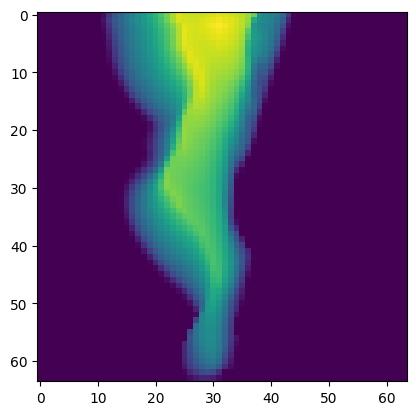

PyObject <matplotlib.image.AxesImage object at 0x7f29ba4a5d80>

In [10]:
using PyPlot
imshow(data[30,:,:,1])

In [ ]:

# Access variables from the file
var1 = read(mat_file, "variable_name1")  # Replace "variable_name1" with the actual variable name in your .mat file
var2 = read(mat_file, "variable_name2")  # Replace "variable_name2" with another variable name if needed

# Close the .mat file
close(mat_file)
